<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/ClassicalAdder_aer_ibm_qpu_%EC%9D%B4%EC%83%81%EC%B9%98%EC%99%80_%EC%8B%A4%EC%B8%A1%EC%B9%98_%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################################
# 코드의 목적: 양자 시뮬레이터의 이상치 결과와 실제 QPU들의 실측치 결과를 비교
# 작성자: 박문기(mkbahk@gmail.com)
# 최초작성일: 20230926
######################################################

In [2]:
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-ibm-provider==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.6 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=c14b60cc12df4139e8f7bdf6b34e549ba0eb361b1094be406462bcfd93143e95
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%pip show qiskit
%pip show qiskit-aer
%pip show qiskit-ibm-provider

Name: qiskit
Version: 1.2.4
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: dill, numpy, python-dateutil, rustworkx, scipy, stevedore, symengine, sympy, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-provider
Name: qiskit-aer
Version: 0.15.1
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, psutil, qiskit, scipy
Required-by: 
Name: qiskit-ibm-provider
Version: 0.11.0
Summary: Qiskit IBM Quantum Provider for accessing the quantum devices and simulators at IBM
Home-page: https://github.com/Qiskit/qiskit-ibm-prov

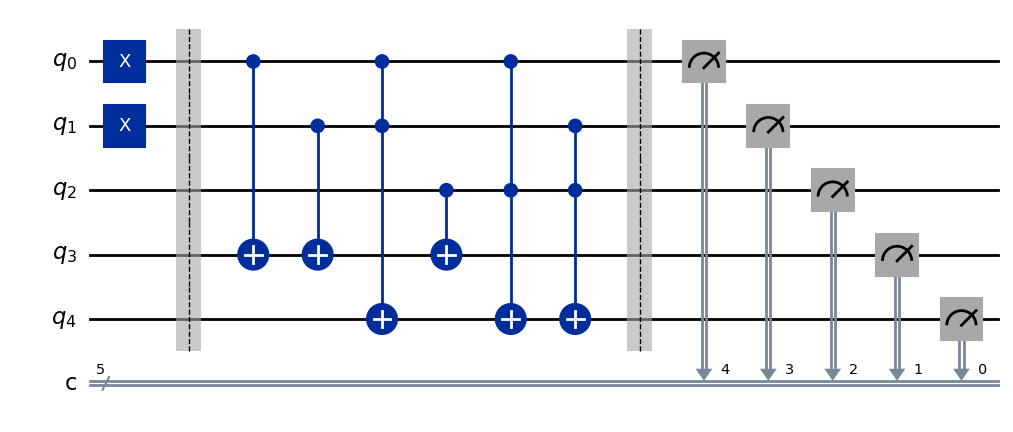

In [4]:
from qiskit import QuantumCircuit

# 양자 회로 생성
qc = QuantumCircuit(5, 5)  # 5개의 양자 비트와 2개의 클래식 비트를 사용합니다.

# 입력 비트 설정 (A=1, B=1)
qc.x(0)  # A 비트를 1로 설정
qc.x(1)  # B 비트를 1로 설정
qc.barrier()

# 반-가산기 회로 구현
qc.cx(0, 3) # XOR 게이트 (A와 B의 논리합)
qc.cx(1, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 1, 4) # AND 게이트 (A와 B의 논리곱)
qc.cx(2, 3) # XOR 게이트 (A와 B의 논리합)
qc.ccx(0, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.ccx(1, 2, 4) # AND 게이트 (A와 B의 논리곱)
qc.barrier()

# 결과를 측정하여 Sum과 Carry 출력을 얻습니다.
qc.measure(0, 4)  # 큐비트를 클래식 비트 4에 매핑
qc.measure(1, 3)  # 큐비트를 클래식 비트 3에 매핑
qc.measure(2, 2)  # 보조비트를 클래식 비트 2에 매핑
qc.measure(3, 1)  # Sum(Result) 비트를 클래식 비트 1에 매핑
qc.measure(4, 0)  # Carry 비트를 클래식 비트 0에 매핑

qc.draw('mpl')

In [5]:
from qiskit.providers.backend import BackendV2

In [6]:
# Qiskit Local Simulator 사용하기 위한 준비
from qiskit_aer import Aer
aer_backend = Aer.get_backend('qasm_simulator')  #Local Qiskit Aer 시뮬레이터 사용
aer_backend

QasmSimulator('qasm_simulator')

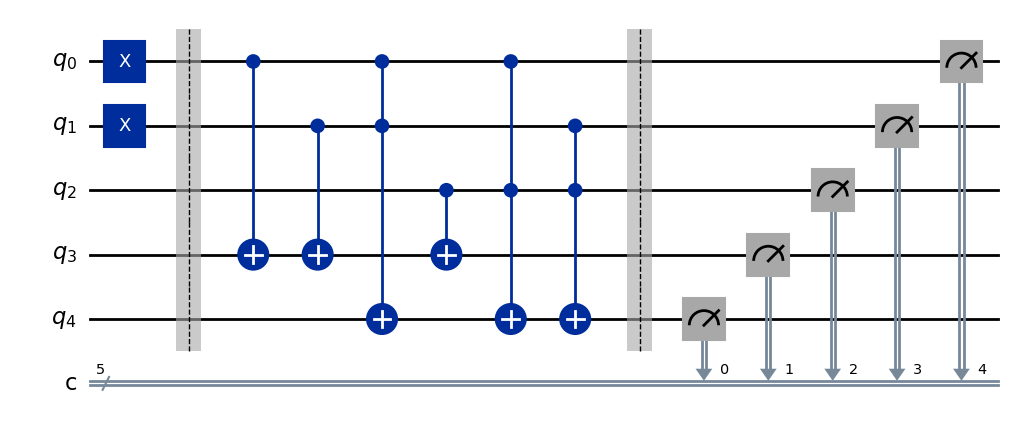

In [7]:
from qiskit.compiler import transpile, assemble
#양자컴 하드웨어마다 지원할 수 있는 Gate의 종류가 달라서, 일반GATE를 각 하드웨어 지원 Gate로 변환하는 과정을 Transpile이라 한다.
aer_trans_qc = transpile(qc, aer_backend)
aer_trans_qc.draw('mpl')

In [8]:
from qiskit.providers.jobstatus import JobStatus
import time

job = aer_backend.run(aer_trans_qc, shots=1024)
#job = backend.run(qc, shots=2048) # if you don’t pass a shots kwarg, it defaults to 1024

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(60)
###while


Job ID is f73236b5-2746-49ac-843a-3feee7f9f51f 



In [9]:
# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [10]:
# 결과 출력
counts = job.result().get_counts()
print(counts)

{'11001': 1024}


# 시뮬레이터의 이상치 결과

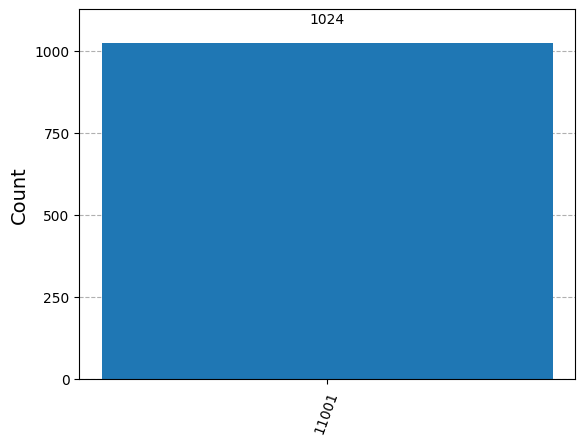

In [11]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)

In [12]:
# 참조: https://github.com/Qiskit/qiskit-ibm-provider/blob/main/docs/tutorials/1_the_ibm_quantum_account.ipynb
# IBM Quantum Platform 서비스 사용하기 위한 준비
from qiskit_ibm_provider import IBMProvider

# IBM  Provider에 등록된 계정 정보를 입력합니다.
IBMProvider.save_account(token='',overwrite=True)

# IBM Provider로 접속합니다.
ibm_provider = IBMProvider()

# 양자회로를 수행한 양자컴퓨터 백엔드 리스트 출력
#print(ibm_provider.backends())
print("Available backends:")

for backend in ibm_provider.backends():
  print(backend.name)
###for

Available backends:
ibm_brisbane
ibm_sherbrooke
ibm_kyiv


In [23]:
ibm_brisbane_backend = ibm_provider.get_backend('ibm_brisbane')
ibm_brisbane_backend

<IBMBackend('ibm_brisbane')>

In [24]:
from qiskit.compiler import transpile, assemble
#양자컴 하드웨어마다 지원할 수 있는 Gate의 종류가 달라서, 일반GATE를 각 하드웨어 지원 Gate로 변환하는 과정을 Transpile이라 한다.
ibm_brisbane_trans_qc = transpile(qc, ibm_brisbane_backend)
#ibm_kyiv_backend_trans_qc.draw('mpl')

In [25]:
ibm_brisbane_trans_qc.draw('mpl')

In [26]:
from qiskit.providers.jobstatus import JobStatus
import time

job = ibm_brisbane_backend.run(ibm_brisbane_trans_qc, shots=1024)
#job = backend.run(qc, shots=2048) # if you don’t pass a shots kwarg, it defaults to 1024

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(60)
###while


Job ID is cx2mng6tpsjg0085n1pg 



In [28]:
# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", job.status() )

Job status is JobStatus.RUNNING


In [ ]:
# Retrieve the job
#job = backend.retrieve_job(job_id)

In [29]:
# 결과 출력
counts = job.result().get_counts()
print(counts)

{'00010': 41, '00101': 4, '00011': 18, '11111': 18, '00001': 17, '11000': 30, '10110': 14, '01001': 13, '01111': 7, '10010': 44, '10100': 12, '10011': 133, '10000': 41, '00000': 44, '01010': 23, '00110': 4, '11010': 33, '10001': 140, '10101': 5, '01011': 17, '00100': 5, '00111': 4, '10111': 15, '01000': 40, '11001': 161, '11011': 107, '11110': 15, '11101': 13, '01110': 3, '01100': 1, '11100': 2}


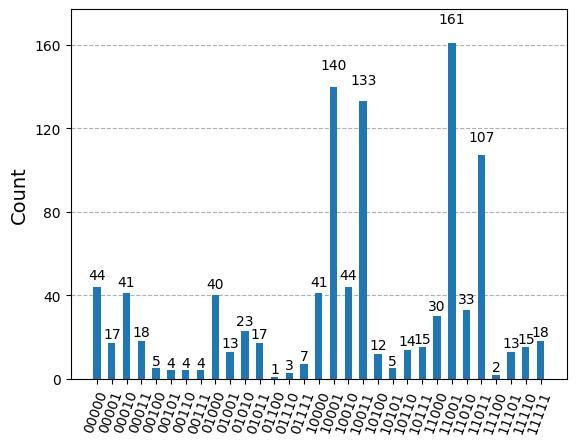

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram(data=counts)